In [ ]:
!pip install harmonypy scikit-misc
!pip install setuptools
!pip install ClustAssessPy
!pip install gdown

In [3]:
import warnings
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import ClustAssessPy as ca
from scipy.io import mmread
import numpy as np

warnings.filterwarnings("ignore")

/Users/rafaelkoll/Desktop/RA/Production_CA/ClustAssessPy/virtual_env_CA_py/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import gdown

cuomo_url = f'https://drive.google.com/uc?id=1ai2-eEwH2NiBQFbWj8XjdDTUmKwgmxeC'
metadata_url = f'https://drive.google.com/uc?id=1Xp0gUAlhveeVMyHNTurJiGIEcnaXznXy'

# Download the files - cuomo dataset and metadata
gdown.download(cuomo_url, "cuomo_expr_matrix_with_MT_RP.csv", quiet=False)
gdown.download(metadata_url, "metadata.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ai2-eEwH2NiBQFbWj8XjdDTUmKwgmxeC
From (redirected): https://drive.google.com/uc?id=1ai2-eEwH2NiBQFbWj8XjdDTUmKwgmxeC&confirm=t&uuid=14de86d0-4a8b-4151-9088-5816fa3debbf
To: /Users/rafaelkoll/Desktop/RA/Production_CA/ClustAssessPy/Examples/cuomo_expr_matrix_with_MT_RP.csv
100%|██████████| 146M/146M [00:24<00:00, 6.02MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1Xp0gUAlhveeVMyHNTurJiGIEcnaXznXy
To: /Users/rafaelkoll/Desktop/RA/Production_CA/ClustAssessPy/Examples/metadata.csv
100%|██████████| 218k/218k [00:00<00:00, 819kB/s]


'metadata.csv'

This tutorial will demonstrate how to use ClustAssessPy on the Cuomo dataset (https://www.nature.com/articles/s41467-020-14457-z). Specifically, 6 donors and 4 time points were chosen, comprising 1880 cells and 35430 expressed genes. The input is provided as a 35430 x 1880 expression level matrix containing the raw quantification (in csv format).

In [15]:
raw_data = pd.read_csv('cuomo_expr_matrix_with_MT_RP.csv', index_col="gene_name")

In [16]:
# Read the gzipped CSV file directly from the URL
cell_metadata = pd.read_csv('metadata.csv', sep=',')
cell_metadata.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [17]:
raw_data.head()

,X21241_6_14,X21241_6_39,X21241_6_41,X21241_6_47,X21241_6_52,X21241_6_54,X21241_6_77,X21241_6_87,X21241_6_91,X21241_6_104,...,X25535_6_306,X25535_6_308,X25535_6_327,X25535_6_329,X25535_6_333,X25535_6_334,X25535_6_335,X25535_6_342,X25535_6_348,X25535_6_375
gene_name,,,,,,,,,,,,,,,,,,,,,
DDX11L1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASH7P,0,1,1,2,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR1302-2HG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
cell_metadata

,id,orig.ident,nCount_RNA,nFeature_RNA,level.ident,day.ident,donor.ident,percent.mt,percent.rp,nCount_SCT,nFeature_SCT,one_level
0,X21241_6_14,X21241,1008331,9281,cuomo,day3,hayt,2.190055,3.083511,498752,8706,one_level
1,X21241_6_39,X21241,465287,5619,cuomo,day3,hayt,8.258989,2.857806,497296,5578,one_level
2,X21241_6_41,X21241,830018,6955,cuomo,day3,hayt,5.774092,3.818351,499444,6811,one_level
3,X21241_6_47,X21241,838279,8341,cuomo,day3,hayt,3.840487,3.274447,499094,8034,one_level
4,X21241_6_52,X21241,304382,8531,cuomo,day3,hayt,7.138398,3.695028,496347,8432,one_level
...,...,...,...,...,...,...,...,...,...,...,...,...
1875,X25535_6_334,X25535,1068066,9001,cuomo,day1,melw,3.812311,9.564203,498922,8282,one_level
1876,X25535_6_335,X25535,552460,9203,cuomo,day1,qunz,3.756652,8.517902,498694,9083,one_level
1877,X25535_6_342,X25535,124075,7194,cuomo,day1,qunz,3.389885,11.223051,499311,13110,one_level
1878,X25535_6_348,X25535,510819,9443,cuomo,day1,qunz,2.897700,8.634565,499041,9318,one_level


SCANPY expects genes on columns and cells on rows, therefore the dataset will be transposed. We will filter cells where at least 200 genes are expressed and genes that are expressed in at least 3 cells.

In [19]:
# Transposing the raw data because scanpy expects genes on columns and cells on rows (opposite of Seurat).
adata = sc.AnnData(raw_data.T)
adata.obs = cell_metadata
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Let's identify the 3000 highly variable (HVGs) and most abundant (MAGs) genes.

In [20]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)

# Get highly variable genes ranked
highly_var_genes_sorted = adata.var['highly_variable_rank'][~adata.var['highly_variable_rank'].isna()].sort_values().index.to_numpy().tolist()

# Get most abundant genes ranked
most_abundant_genes_sorted = pd.Series(adata.X.sum(axis=0), index=adata.var_names).sort_values(ascending=False).head(3000).index.tolist()

Due to technical variability in sequencing depth across cells, raw gene expression counts cannot be directly compared. We will use normalization to make the data comparable across cells and mitigate the influence of cell-specific biases, such as differences in capture efficiency or RNA content, which are unrelated to the biological differences of interest. 

After normalization, we will scale the data. This ensures that the expression levels of genes across cells to have a mean of 0 and a variance of 1 which is crucial for downstream analyses that assume data is centered (e.g., PCA). By scaling we ensure that high-abundance genes do not dominate the signal simply due to their larger numerical values, allowing genes with lower expression levels but potentially high biological significance to contribute equally to the analysis.

In [21]:
# Normalise data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Scale the data
sc.pp.scale(adata)

# Get scaled data.
scaled_data = adata.to_df()

In [22]:
adata.obs

,id,orig.ident,nCount_RNA,nFeature_RNA,level.ident,day.ident,donor.ident,percent.mt,percent.rp,nCount_SCT,nFeature_SCT,one_level,n_genes
0,X21241_6_14,X21241,1008331,9281,cuomo,day3,hayt,2.190055,3.083511,498752,8706,one_level,9281
1,X21241_6_39,X21241,465287,5619,cuomo,day3,hayt,8.258989,2.857806,497296,5578,one_level,5619
2,X21241_6_41,X21241,830018,6955,cuomo,day3,hayt,5.774092,3.818351,499444,6811,one_level,6955
3,X21241_6_47,X21241,838279,8341,cuomo,day3,hayt,3.840487,3.274447,499094,8034,one_level,8341
4,X21241_6_52,X21241,304382,8531,cuomo,day3,hayt,7.138398,3.695028,496347,8432,one_level,8531
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,X25535_6_334,X25535,1068066,9001,cuomo,day1,melw,3.812311,9.564203,498922,8282,one_level,9001
1876,X25535_6_335,X25535,552460,9203,cuomo,day1,qunz,3.756652,8.517902,498694,9083,one_level,9203
1877,X25535_6_342,X25535,124075,7194,cuomo,day1,qunz,3.389885,11.223051,499311,13110,one_level,7194
1878,X25535_6_348,X25535,510819,9443,cuomo,day1,qunz,2.897700,8.634565,499041,9318,one_level,9443


Batch effects are systematic non-biological differences between batches of data, which can arise from variations in sample preparation, sequencing protocols, or experimental conditions. A batch effect can obscure biological signals and lead to incorrect conclusions, as apparent differences between cells may reflect technical variability rather than true biological diversity. For studies involving samples collected over multiple days, as in the Cuomo dataset, it's crucial to correct for these day-to-day variations to ensure that subsequent analyses reveal genuine biological differences rather than artifacts of the collection process.

To apply Harmony batch correction based on the day the samples were taken, we will use SCANPY's external interface to Harmony.

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

# Run harmony batch correction
sce.pp.harmony_integrate(adata, 'day.ident')

# Get pca embdeddings after batch correction
pca_embs = adata.obsm['X_pca_harmony']

2024-06-03 22:08:04,975 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-03 22:08:05,948 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-03 22:08:05,954 - harmonypy - INFO - Iteration 1 of 10
2024-06-03 22:08:06,156 - harmonypy - INFO - Iteration 2 of 10
2024-06-03 22:08:06,474 - harmonypy - INFO - Converged after 2 iterations


Now let's visualise the data using UMAP colouring by day and donor.

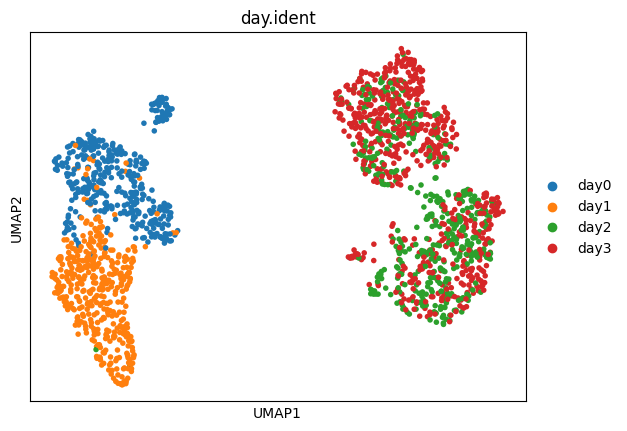

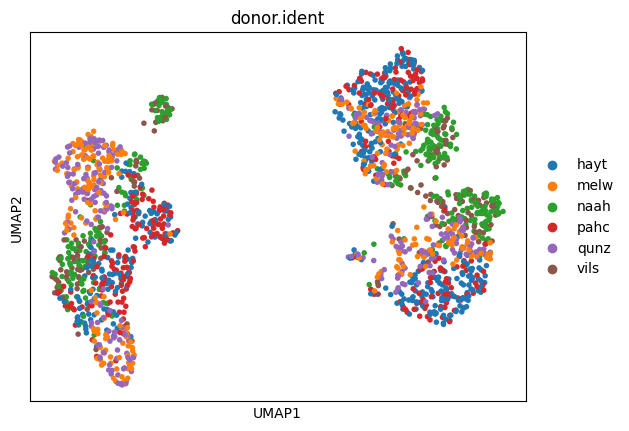

In [24]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep="X_pca_harmony") 
sc.tl.umap(adata)

# Show UMAP plot colored by day and donor
sc.pl.umap(adata, color='day.ident')
sc.pl.umap(adata, color='donor.ident')

# Dimensionality Reduction

In scRNA-seq analysis, feature selection is pivotal for refining the dataset to include genes that contribute the most to cell heterogeneity and biological signal.

The first step that we will evaluate and note to substantially influence the dimensionality reduction (linear or non-linear) is the feature set. The top x most variable genes or most abundant genes can be selected, where x varies according to the characteristics of the dataset; frequently used values are 500, 1000, 2000, 3000 etc.

To showcase the importance of this parameter, we assess two different sets of features:

1) highly variable genes (HVGs): this set can be obtained from SCANPY by running highly_variable_genes.
2) most abundant genes (MAGs): this set can be obtained by sorting the genes based on their expression level.


In [26]:
feature_stability_HV = ca.assess_feature_stability(data_matrix = scaled_data, feature_set = highly_var_genes_sorted, steps = [500, 1000, 1500, 2000, 2500, 3000], feature_type = 'HV', resolution = [0.3, 0.5, 0.7], n_repetitions=50, algorithm='leiden', ncores=8)

FutureWarnings (caused by ScanPy for Leiden) will be suppressed. Set show_warnings=True to see them.


In [25]:
feature_stability_MA = ca.assess_feature_stability(data_matrix = scaled_data, feature_set = most_abundant_genes_sorted, steps = [500, 1000, 1500, 2000, 2500, 3000], feature_type = 'MA', resolution = [0.3, 0.5, 0.7], n_repetitions=50, algorithm='leiden', ncores=8)

FutureWarnings (caused by ScanPy for Leiden) will be suppressed. Set show_warnings=True to see them.


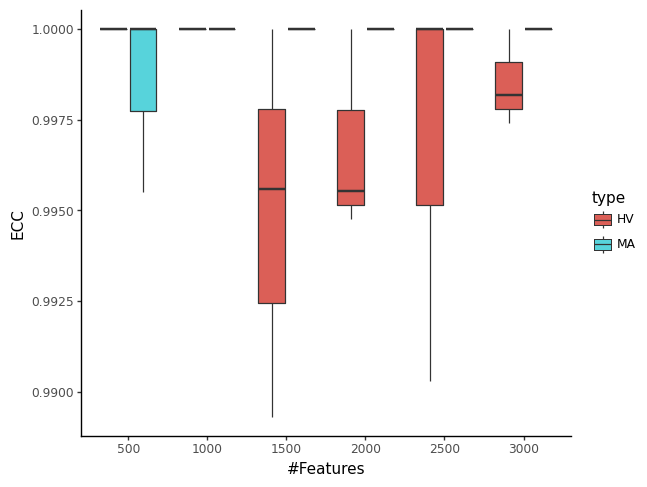

In [27]:
ca.plot_feature_overall_stability_boxplot([feature_stability_HV, feature_stability_MA])

The plot illustrates the stability assessment, across 50 runs, each with different random seeds, on the two gene sets described above. We assessed the stability of each set on incremental number of selected genes, starting from 500 and finishing at 3000 (incrementing by 500 on each step). The Leiden algorithm was used for clustering.

The clustering partitions across all the different configurations are very stable (median ECC for all > 0.99). Interestingly, MAGs consistently showed greater stability than HVGs, except at the 1000-gene mark, where both reached an ECC of 1.0.



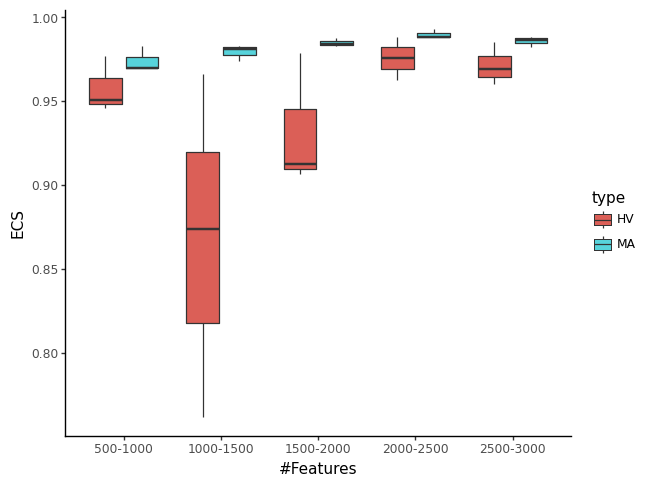

In [28]:
ca.plot_feature_overall_stability_incremental([feature_stability_HV, feature_stability_MA])

Another angle for assessing the stability is centered on the comparison between consecutive steps, for each feature set, performed using the Element-Centric Similarity on the most frequent partitions from each step. The aim is evaluating the effect of increasing the number of genes on the final partitions, and, indirectly, determining the transition from the signal to the noise zone. For the Cuomo case study, we observe an increase in similarity between consecutive steps for the most abundant and highly variable genes, suggesting that selecting more genes would lead to a more robust partitioning. However, this trend plateaus and then subtly descends as we cross the 2500-gene mark, suggesting a pivotal transition point where the signal-to-noise ratio is no longer favorable. Beyond this threshold, it appears that the extra genes incorporated may be embedding more noise than biological signal into the data, diluting the previously gained stability and potentially obfuscating the true biological variance we seek to capture.

# Graph Construction

The next step in a standard single-cell analysis pipeline is building the graph using the nearest neighbour algorithm. The following parameters influence the final partitioning:

1) base embedding: the graph can be built on either the PCA or the UMAP embedding (using the expression matrix isn’t recommended, as the distances would be noisier and the runtime would increase)
2) Number of neighbours
3) Graph Type: the graph can be either unweighted (NN case) or based on a weighted Shared-Nearest Neighbours (SNN) graph. For the latter, the weights are computed using the Jaccard Similarity Index (JSI) between the neighbourhoods of two cells.

In [20]:
# NN stability assessment
nn_stability_obj_leiden = ca.assess_nn_stability(pca_embs, n_neigh_sequence=[5, 10, 15, 20, 25, 30], n_repetitions = 50, algorithm = 'leiden', graph_type = 2, ncores=8)

FutureWarnings (caused by ScanPy for Leiden) will be suppressed. Set show_warnings=True to see them.


In [24]:
# Required to do umap assessment in parallel. This is a requirement of the UMAP and Numba libraries.
from numba import config
config.THREADING_LAYER = 'tbb'
!numba -s | grep TBB

TBB Threading Layer Available                 : True
+-->TBB imported successfully.


In [22]:
nn_stability_obj_leiden_umap = ca.assess_nn_stability(pca_embs, n_neigh_sequence=[5, 10, 15, 20, 25, 30], graph_reduction_type = "UMAP", n_repetitions = 50, algorithm = 'leiden', graph_type = 2, ncores=9)

FutureWarnings (caused by ScanPy for Leiden) will be suppressed. Set show_warnings=True to see them.


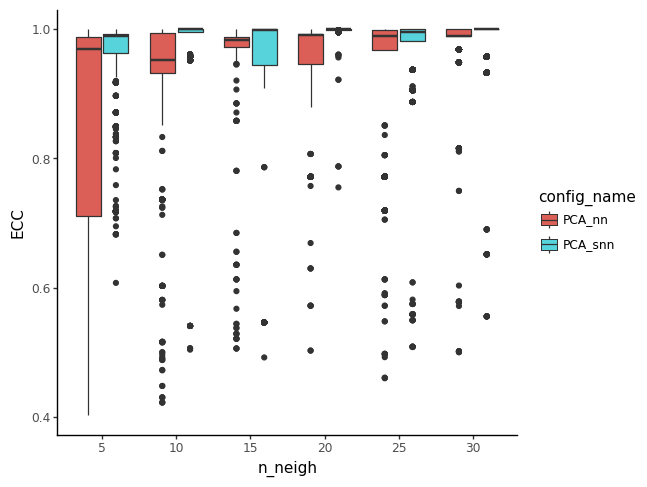

In [21]:
ca.plot_n_neigh_ecs(nn_stability_obj_leiden)

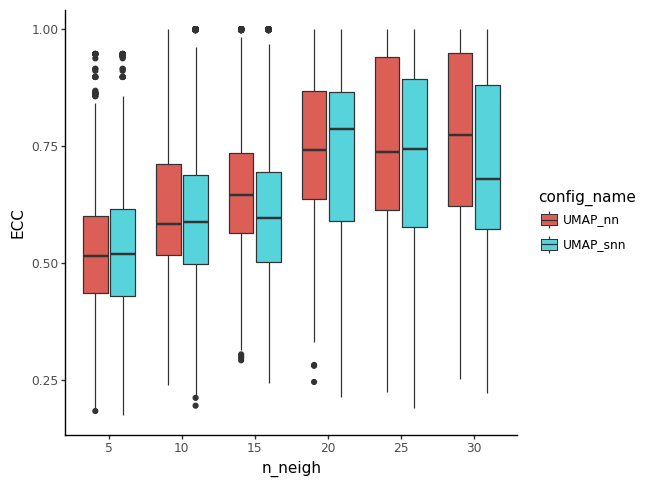

In [24]:
ca.plot_n_neigh_ecs(nn_stability_obj_leiden_umap)

The PCA embedding appears to be significantly more stable than UMAP, both for NN and SNN graph types. Utilizing the PCA embedding, SNN graph results in consistently more stable partitions than NN. 

The most stable outcomes for our dataset over 50 iterations are observed when employing PCA with an SNN approach and setting the number of neighbors to 20.

# Graph Clustering

The final step in a standard single-cell analysis pipeline is applying a graph-based clustering method. Choosing a community detection algorithm has a significant impact on the partitioning results. In this section, we will examine the relative stability of the two clustering algorithms offered in SCANPY—Louvain and Leiden—and assess how the resolution parameter affects both the number of clusters and the covariance between the stability of number of clusters and the number of different partitions.

In [25]:
# Get SNN matrix from pca using 20 neighbours
snn_matrix = ca.get_adjacency_matrix_wrapper(pca_embs, 20)['snn']

In [27]:
clust_stability = ca.assess_clustering_stability(
    graph_adjacency_matrix=snn_matrix,
    resolution=[0.1, 0.3, 0.5, 0.7, 0.9],
    n_repetitions=50,
    algorithms=['louvain','leiden'],
    ncores=8
)

FutureWarnings (caused by ScanPy for Leiden) will be suppressed. Set show_warnings=True to see them.


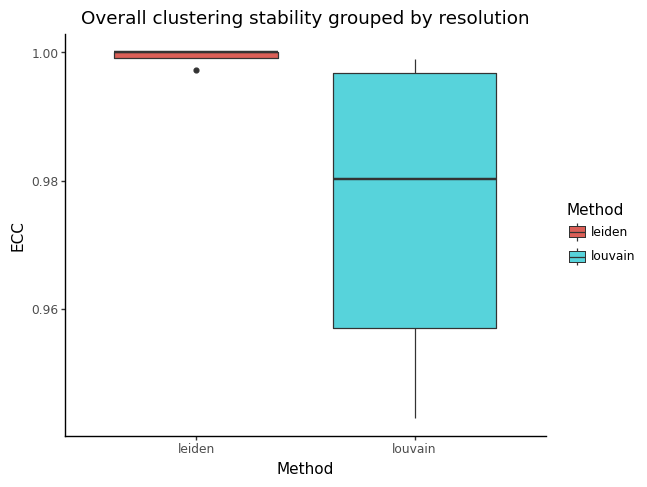

In [28]:
ca.plot_clustering_overall_stability(clust_stability, value_type="resolution")

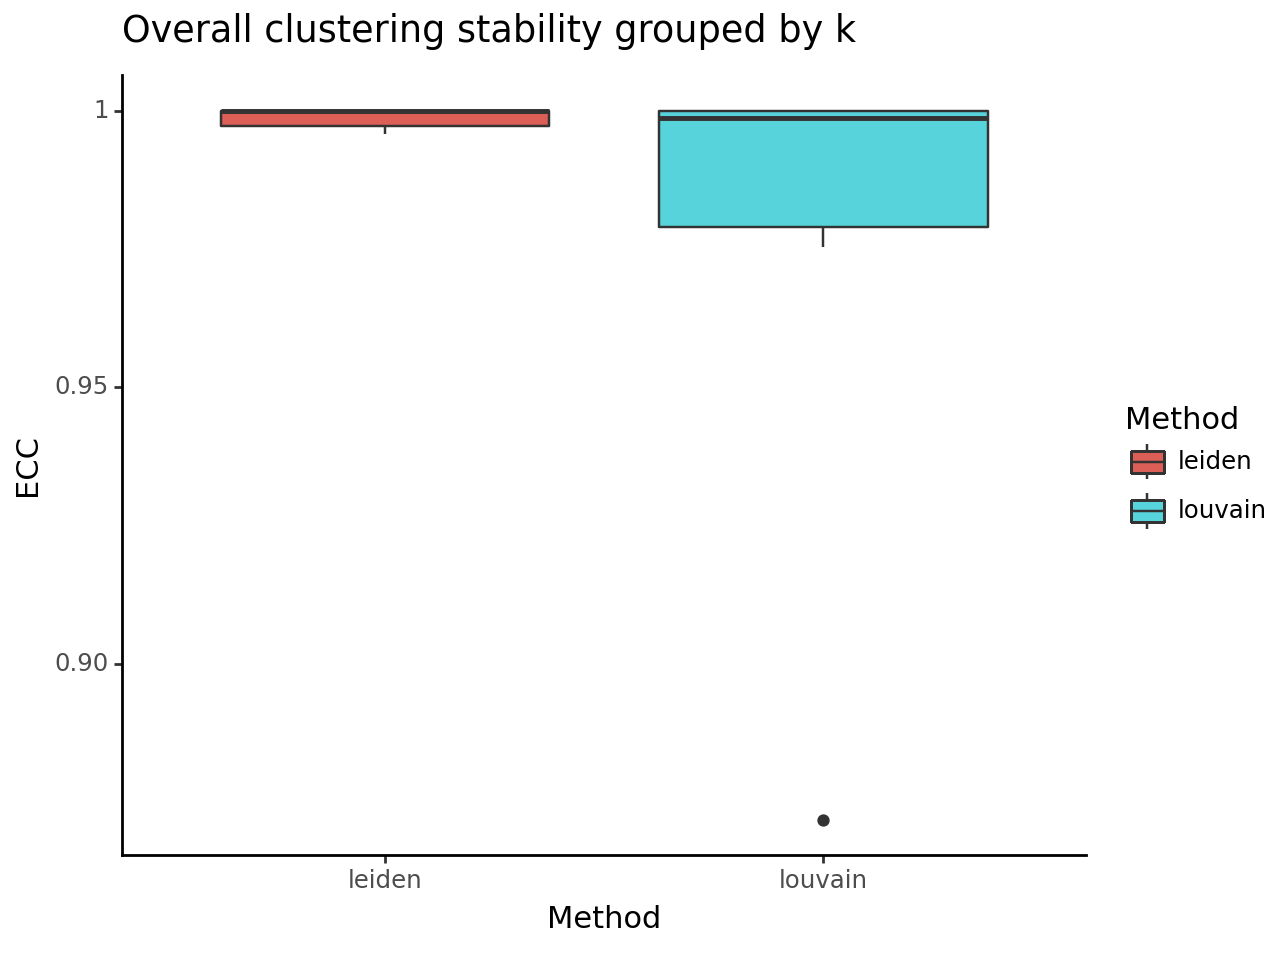

In [35]:
ca.plot_clustering_overall_stability(clust_stability, value_type="k")

Both the Leiden and Louvain algorithms exhibit high median Element Centric Consistency (ECC) scores across iterations, indicative of robust clustering performance. The Leiden algorithm demonstrates greater stability, as evidenced by the narrower distribution of ECC scores when grouped by both k (number of clusters) and resolution parameters. This suggests that within each k or resolution setting, the Leiden algorithm consistently generates partitions that are almost identical. On the other hand, the Louvain algorithm displays a broader range of ECC scores, implying greater variability in its clustering outcomes.

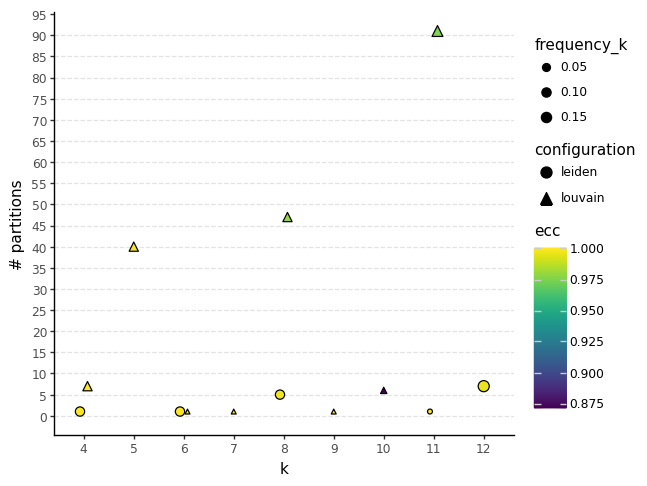

In [29]:
ca.plot_k_n_partitions(clust_stability)

The above plot showcases the co-variation between the stability of the number of clusters and the number of different partitions resulting from changes on the seed or the resolution parameter. A high number of different partitions indicates a lower stability for a given number of clusters. The colour gradient is proportional to the ECC as an indicator of robustness. The size indicates the frequency of the partition having k clusters relative to the total number of runs and should provide additional information whether the behaviour described by the colour is replicated in multiple instances or not. We note that, even if we obtain a high number of different partitions, if the frequency of the most common one is close to 1, then the overall stability is high. Observing a high number of partitions, each with low frequency, indicates high instability.


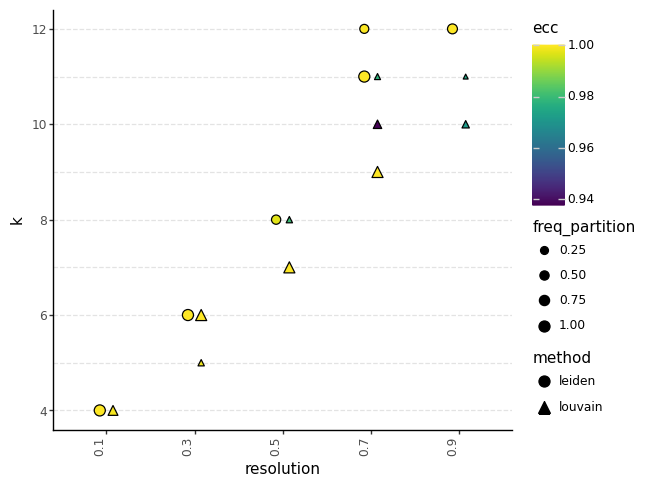

In [30]:
ca.plot_k_resolution_corresp(clust_stability)

The above plot showcase the relationship between the number of clusters and the resolution value. This plot also provides information on suitable resolution values for predefined number of clusters. The colour gradient represents the ECC of the partitions. It can also be used as proxy to describe the co-variation between (k, resolution). Lighter (higher) values indicate that little variation is observed, on changes of the random seed, between the number of clusters and the resolution value. The size illustrates the frequency of the most common partition when the resolution and the number of clusters values are fixed.